# **Heart Disease Prediction**

## **Model Selection and Optimization**  
This notebook focuses on the process of **selecting and optimizing the best machine learning model** for predicting heart disease. The goal is to identify a model that outperforms the baseline while ensuring robustness and generalization.

The models at least has to be better than the baseline model (heuristic approach). Modelo Base

All steps will be implemented using **scikit-learn** and other relevant libraries to ensure a structured and reproducible workflow.  

`Simón Correa Marín`


### **1. Import Libraries and Configurations**

In [1]:
# base libraries for data science
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import (
    KFold,
    ShuffleSplit,
    cross_val_score,
    learning_curve,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder


### **2. Load Data**

In [2]:
DATA_DIR = Path.cwd().resolve().parents[0] / "data"

hd_df = pd.read_parquet(
    DATA_DIR / "02_intermediate/hd_type_fixed.parquet", engine="pyarrow"
)

In [3]:
# print library version for reproducibility

print("Pandas version: ", pd.__version__)

Pandas version:  2.2.3


### **3. Data Preparation**

I'll be using all columns since I found no strange correlations.

In [4]:
df_corr = hd_df.copy()

# Convert all boolean columns to int
boolean_cols = ['exang','fbs', 'disease']
df_corr[boolean_cols] = df_corr[boolean_cols].astype("int")
df_corr[boolean_cols] = df_corr[boolean_cols].astype("category")

In [5]:
from dython.nominal import associations

# Calculate the correlation matrix including the categorical columns
correlation_matrix = associations(df_corr, nominal_columns="auto", mark_columns=True, plot=False)

corr_df = correlation_matrix["corr"]
correlation_with_target = corr_df.loc[:, 'disease (nom)'].sort_values(ascending=False)
print(correlation_with_target)


disease (nom)       1.000000
thal (nom)          0.540319
chest_pain (nom)    0.489392
exang (nom)         0.429343
ca (con)            0.411784
old_peak (con)      0.367464
max_hr (con)        0.328349
sex (nom)           0.256091
rest_ecg (nom)      0.209428
slope (con)         0.203885
age (con)           0.174258
rest_bp (con)       0.069305
chol (con)          0.038271
fbs (nom)           0.032144
Name: disease (nom), dtype: float64


**Irrelevant variables**

- chol (con)          0.038271
- fbs (nom)           0.032144

In [6]:
# Drop columns with low correlation with the target
hd_df.drop(columns=['fbs', 'chol'], inplace=True)

In [7]:
hd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6848 entries, 0 to 6847
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   rest_ecg    6392 non-null   category
 1   ca          6479 non-null   float64 
 2   thal        6552 non-null   category
 3   max_hr      6453 non-null   float64 
 4   exang       6848 non-null   bool    
 5   old_peak    6493 non-null   float64 
 6   rest_bp     6655 non-null   float64 
 7   chest_pain  6648 non-null   category
 8   disease     6848 non-null   bool    
 9   sex         6692 non-null   category
 10  slope       6492 non-null   float64 
 11  age         6763 non-null   float64 
dtypes: bool(2), category(4), float64(6)
memory usage: 361.8 KB


#### **Missing Values**

In [8]:
hd_df.isna().sum()

rest_ecg      456
ca            369
thal          296
max_hr        395
exang           0
old_peak      355
rest_bp       193
chest_pain    200
disease         0
sex           156
slope         356
age            85
dtype: int64

#### **Duplicated Data**

In [9]:
duplicate_rows = hd_df.duplicated().sum()
print("Number of duplicate rows: ", duplicate_rows)

Number of duplicate rows:  6347


In [10]:
hd_df = hd_df.drop_duplicates()
hd_df.shape

(501, 12)

There are 508 rows left after deleting duplicated rows

In [11]:
# Missing values after dropping duplicates
hd_df.isna().sum()

rest_ecg      143
ca             89
thal           74
max_hr        121
exang           0
old_peak      107
rest_bp        56
chest_pain     58
disease         0
sex            43
slope         107
age            17
dtype: int64

In [12]:
# Encode target variable
hd_df["disease"] = hd_df["disease"].astype("int64")
# True = 1, False = 0

In [13]:
hd_df.sample(10)

,rest_ecg,ca,thal,max_hr,exang,old_peak,rest_bp,chest_pain,disease,sex,slope,age
487,normal,0.0,normal,172.0,False,0.0,105.0,nontypical,0,Female,1.0,46.0
853,NaN,NaN,NaN,NaN,True,NaN,108.0,nonanginal,1,Male,NaN,47.0
620,NaN,NaN,NaN,NaN,True,NaN,138.0,asymptomatic,1,Male,NaN,61.0
379,normal,0.0,reversable,130.0,True,1.6,120.0,asymptomatic,1,Male,2.0,35.0
96,normal,0.0,normal,175.0,False,0.6,108.0,nonanginal,0,Female,2.0,44.0
337,left ventricular hypertrophy,0.0,normal,174.0,False,0.0,118.0,typical,1,Male,1.0,34.0
153,left ventricular hypertrophy,2.0,normal,152.0,False,0.0,136.0,nontypical,1,Female,1.0,58.0
268,left ventricular hypertrophy,0.0,normal,172.0,False,0.0,135.0,nonanginal,0,Female,1.0,63.0
1373,NaN,0.0,normal,NaN,True,NaN,104.0,asymptomatic,0,Male,NaN,NaN
1029,NaN,0.0,normal,NaN,False,0.0,NaN,NaN,0,NaN,1.0,55.0


### **3. Feature Engineering**

In [14]:
nom_categorical_cols = ["chest_pain", "rest_ecg", "thal", "sex"]
ord_categorical_cols = ["ca", "slope"]
disc_numerical_cols = ["age", "max_hr", "rest_bp"] #dropped chol
cont_numerical_cols = ["old_peak"]
boolean_cols = ["exang"] #dropped fbs

#### **Pipeline**

In [15]:
from sklearn.preprocessing import FunctionTransformer

numeric_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ]
)

nom_categorical_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(drop="if_binary")),
    ]
)

ord_categorical_ord_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OrdinalEncoder()),
    ]
)

def convert_to_int(X):
    return X.astype("int64")

boolean_pipe = Pipeline(
    steps=[
        ("to_int", FunctionTransformer(convert_to_int, feature_names_out="one-to-one")),
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(drop="if_binary")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipe, disc_numerical_cols+cont_numerical_cols),
        ("nominal_categoric", nom_categorical_pipe, nom_categorical_cols),
        ("ordinal_categoric", ord_categorical_ord_pipe, ord_categorical_cols),
        ("boolean", boolean_pipe, boolean_cols),
    ]
)


In [16]:
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['age', 'max_hr', 'rest_bp', 'old_peak']),
                                ('nominal_categoric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='if_binary'))]),
                                 ['chest_pain', 'rest_ecg', 'thal', 'sex']),
                                ('ordinal_categoric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot', OrdinalEncoder())]),
                                 ['ca', 'slope']),
                                ('boolean',
                                 Pipeline(steps=[('to_int',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function convert_to_int at 0x123fdfb00>)),
                                                 ('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='if_binary'))]),
                                 ['exang'])])

#### **Train/Test split**

In [17]:
X_features = hd_df.drop("disease", axis="columns")
Y_target = hd_df["disease"]

# 80% train, 20% test
x_train, x_test, y_train, y_test = train_test_split(
    X_features, Y_target, test_size=0.2, stratify=Y_target
)

In [18]:
x_train.shape, y_train.shape

((400, 11), (400,))

In [19]:
x_test.shape, y_test.shape

((101, 11), (101,))

In [20]:
print(x_train.dtypes)

rest_ecg      category
ca             float64
thal          category
max_hr         float64
exang             bool
old_peak       float64
rest_bp        float64
chest_pain    category
sex           category
slope          float64
age            float64
dtype: object


#### **Preprocessing Pipeline**

In [21]:
transformed_data = preprocessor.fit(x_train)
feature_names = preprocessor.get_feature_names_out()

In [22]:
# Transform X_test with preprocessor and pandas output set
x_train_transformed = preprocessor.transform(x_train)
x_train_transformed = pd.DataFrame(x_train_transformed, columns=feature_names)

In [23]:
x_train_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 18 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   numeric__age                                               400 non-null    float64
 1   numeric__max_hr                                            400 non-null    float64
 2   numeric__rest_bp                                           400 non-null    float64
 3   numeric__old_peak                                          400 non-null    float64
 4   nominal_categoric__chest_pain_asymptomatic                 400 non-null    float64
 5   nominal_categoric__chest_pain_nonanginal                   400 non-null    float64
 6   nominal_categoric__chest_pain_nontypical                   400 non-null    float64
 7   nominal_categoric__chest_pain_typical                      400 non-null    float64
 8   nominal_ca

In [24]:
x_train_transformed.head()

,numeric__age,numeric__max_hr,numeric__rest_bp,numeric__old_peak,nominal_categoric__chest_pain_asymptomatic,nominal_categoric__chest_pain_nonanginal,nominal_categoric__chest_pain_nontypical,nominal_categoric__chest_pain_typical,nominal_categoric__rest_ecg_ST-T wave abnormality,nominal_categoric__rest_ecg_left ventricular hypertrophy,nominal_categoric__rest_ecg_normal,nominal_categoric__thal_fixed,nominal_categoric__thal_normal,nominal_categoric__thal_reversable,nominal_categoric__sex_Male,ordinal_categoric__ca,ordinal_categoric__slope,boolean__exang_1
0,55.0,152.0,130.0,0.6,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,70.0,109.0,130.0,2.4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,3.0,1.0,0.0
2,45.0,152.0,138.0,0.2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
3,54.0,165.0,130.0,1.6,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,53.0,143.0,130.0,0.4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### **4. Models**

Best Practices is to import the libraries at the beginning of the notebook, but for this notebook, the libraries are imported in the cell where they are used.

In this experiments Basic Machine Learning models are used, and the models are:

- Logistic Regression
- Linear Discriminant Analysis
- Stochastic Gradient Descent classifier
- Linear Support Vector Machine
- Radius Neighbors Classifier
- Gaussian Naive Bayes
- Decision Tree
- Random Forest

In [25]:
# Model libraries
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

#### **Basic Model Selection**
The models are trained with the default hyperparameters, and the models with the best performance will be selected to be tuned in the next step.

#### **Helping functions**

In [26]:
def summarize_classification(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred, normalize=True)
    prec = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)

    return {"accuracy": acc, "precision": prec, "recall": recall, "f1": f1, "roc": roc}

In [27]:
def build_model(
    classifier_fn,
    preprocessor: ColumnTransformer,
    data_params: dict,
    test_frac: float = 0.2,
) -> dict:
    """
    Function to train a classification model

    Args:
        classifier_fn: classification function
        preprocessor (ColumnTransformer): preprocessor pipeline object
        data_params (dict): dictionary containing 'name_of_y_col',
                            'names_of_x_cols', and 'dataset'
        test_frac (float): fraction of data for the test, default 0.2

    Returns:
        dict: dictionary with the model performance metrics on train and test

    """

    # Extract data parameters
    name_of_y_col = data_params["name_of_y_col"]
    names_of_x_cols = data_params["names_of_x_cols"]
    dataset = data_params["dataset"]

    # Separate the feature columns and the target column
    X = dataset[names_of_x_cols]
    Y = dataset[name_of_y_col]

    # Split the data into train and test
    x_train, x_test, y_train, y_test = train_test_split(
        X, Y, test_size=test_frac, random_state=1234
    )

    # Create the pipeline with preprocessing and the classification model
    classifier_pipe = Pipeline(
        steps=[("preprocessor", preprocessor), ("model", classifier_fn)]
    )

    # Train the classifier pipeline
    model = classifier_pipe.fit(x_train, y_train)

    # Predict the test data
    y_pred = model.predict(x_test)

    # Predict the train data
    y_pred_train = model.predict(x_train)

    # Calculate the performance metrics
    train_summary = summarize_classification(y_train, y_pred_train)
    test_summary = summarize_classification(y_test, y_pred)

    return {"train": train_summary, "test": test_summary}

#### **First Selection of Models**

The idea is to do a simple train an evaluate the models to see which ones are the worst to discard them.

In [28]:
FEATURES = list(x_train.columns)
FEATURES

['rest_ecg',
 'ca',
 'thal',
 'max_hr',
 'exang',
 'old_peak',
 'rest_bp',
 'chest_pain',
 'sex',
 'slope',
 'age']

#### **Simple Training and Evaluation**

In [29]:
result_dict = {}
models = {
    "logistic": LogisticRegression(solver="liblinear"),
    "lda": LinearDiscriminantAnalysis(),
    "sgd": SGDClassifier(),
    "svc": LinearSVC(C=1.0, max_iter=1000, tol=1e-3, dual=False),
    "radius_neighbors": RadiusNeighborsClassifier(radius=40.0),
    "naive_bayes": GaussianNB(),
    "decision_tree": DecisionTreeClassifier(),
    "random_forest": RandomForestClassifier(),
}

data_params = {
    "name_of_y_col": "disease",
    "names_of_x_cols": FEATURES,
    "dataset": hd_df,
}
for model_name, model in models.items():
    result_dict[model_name] = build_model(model, preprocessor, data_params)

#### **Model Comparison**

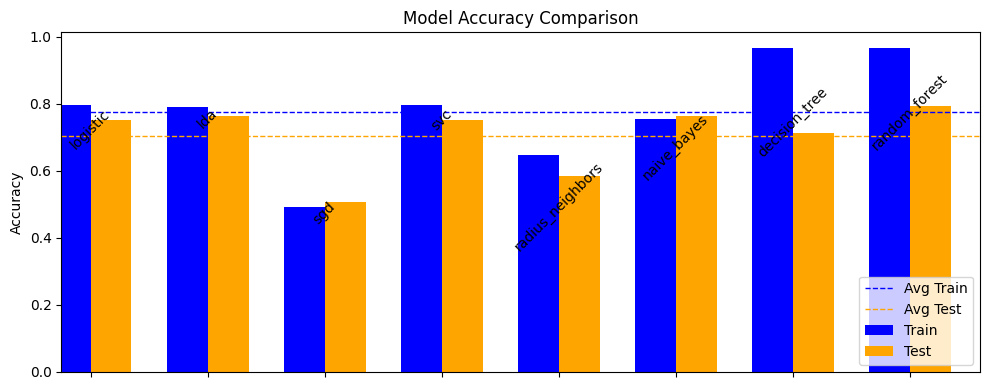

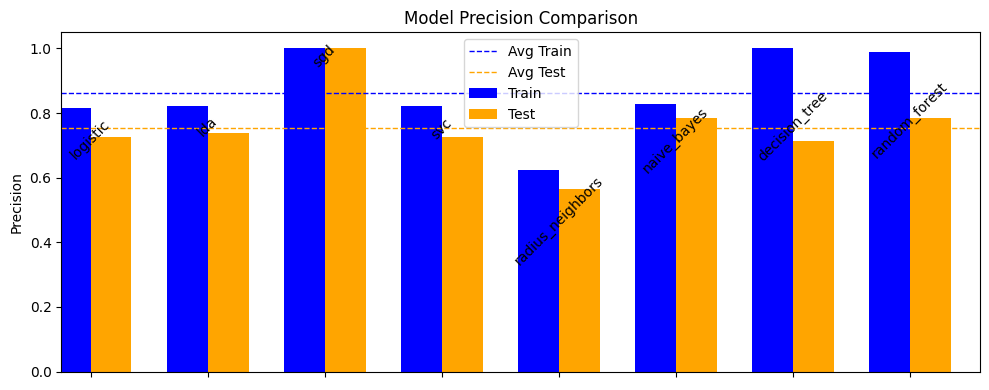

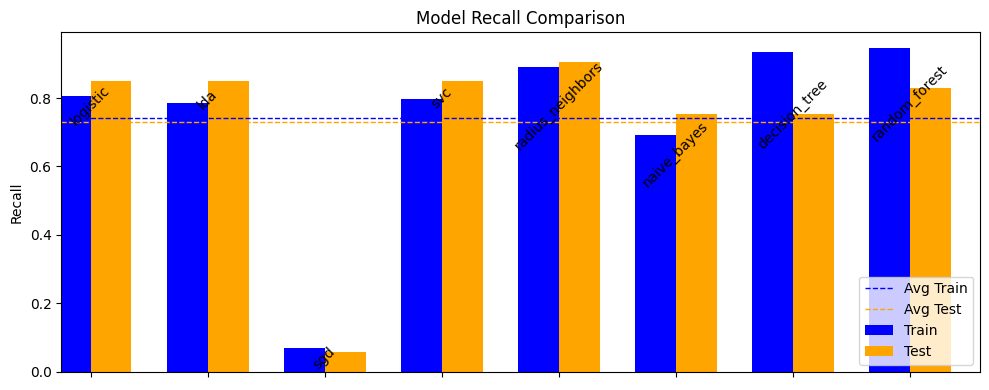

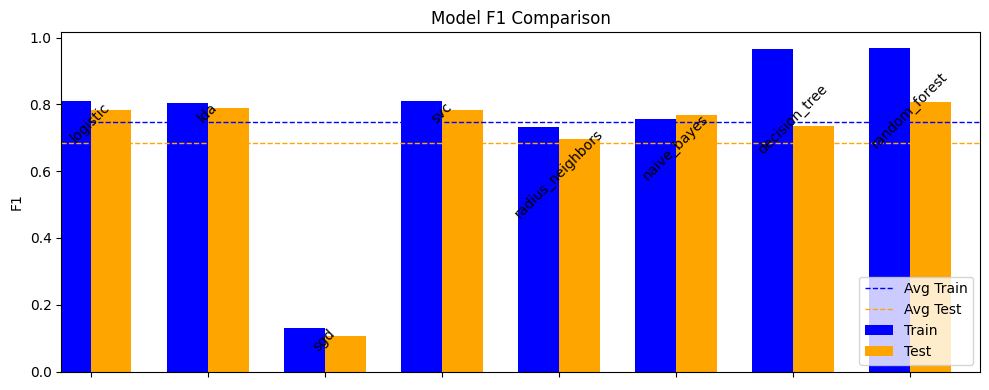

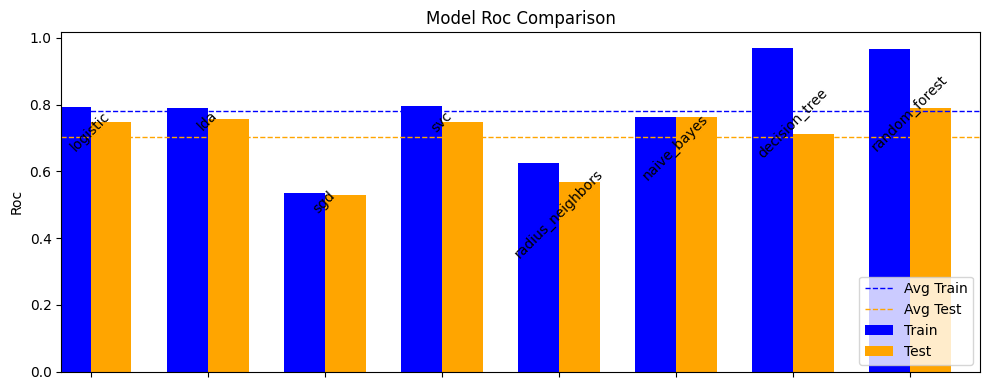

In [30]:
# Convert the result_dict to a DataFrame for easier plotting
metrics = ["accuracy", "precision", "recall", "f1", "roc"]
models = list(result_dict.keys())
data_train = {
    metric: {model: result_dict[model]["train"][metric] for model in models}
    for metric in metrics
}
data_test = {
    metric: {model: result_dict[model]["test"][metric] for model in models}
    for metric in metrics
}

df_train = pd.DataFrame(data_train)
df_test = pd.DataFrame(data_test)

# Plot the bar chart for each metric
for metric in metrics:
    fig, ax = plt.subplots(figsize=(10, 4))
    width = 0.35  # the width of the bars

    df_train[metric].plot(
        kind="bar", ax=ax, width=width, position=1, label="Train", color="blue"
    )
    df_test[metric].plot(
        kind="bar", ax=ax, width=width, position=0, label="Test", color="orange"
    )

    # Add horizontal lines for average performance
    avg_train = df_train[metric].mean()
    avg_test = df_test[metric].mean()
    ax.axhline(avg_train, color="blue", linestyle="--", linewidth=1, label="Avg Train")
    ax.axhline(avg_test, color="orange", linestyle="--", linewidth=1, label="Avg Test")

    # Adjust the layout
    ax.set_ylabel(metric.capitalize())
    ax.set_title(f"Model {metric.capitalize()} Comparison")
    ax.legend()

    # Set the x-tick labels inside the bars and rotate by 90 degrees
    ax.set_xticks(range(len(df_train.index)))
    ax.set_xticklabels([])

    # Draw the x-tick labels inside the bars rotated by 90 degrees
    for i, label in enumerate(df_train.index):
        bar_center = (df_train.loc[label, metric] + df_test.loc[label, metric]) / 2
        ax.text(i, bar_center, label, ha="center", va="center_baseline", rotation=45)

    plt.tight_layout()
    plt.show()

In [31]:
print(df_train)
print(df_test)

                  accuracy  precision    recall        f1       roc
logistic            0.7950   0.814815  0.807339  0.811060  0.793780
lda                 0.7900   0.822115  0.784404  0.802817  0.790553
sgd                 0.4925   1.000000  0.068807  0.128755  0.534404
svc                 0.7950   0.820755  0.798165  0.809302  0.794687
radius_neighbors    0.6475   0.623794  0.889908  0.733459  0.623526
naive_bayes         0.7550   0.829670  0.692661  0.755000  0.761165
decision_tree       0.9650   1.000000  0.935780  0.966825  0.967890
random_forest       0.9650   0.990385  0.944954  0.967136  0.966983
                  accuracy  precision    recall        f1       roc
logistic          0.752475   0.725806  0.849057  0.782609  0.747445
lda               0.762376   0.737705  0.849057  0.789474  0.757862
sgd               0.504950   1.000000  0.056604  0.107143  0.528302
svc               0.752475   0.725806  0.849057  0.782609  0.747445
radius_neighbors  0.584158   0.564706  0.905660 

In [32]:
# Create a DataFrame combining df_train and df_test
df_combined = pd.concat(
    [df_train.add_suffix("_train"), df_test.add_suffix("_test")], axis=1
)

# Calculate the difference between train and test values
df_combined["accuracy_diff"] = (
    df_combined["accuracy_train"] - df_combined["accuracy_test"]
)
df_combined["precision_diff"] = (
    df_combined["precision_train"] - df_combined["precision_test"]
)
df_combined["recall_diff"] = df_combined["recall_train"] - df_combined["recall_test"]
df_combined["f1_diff"] = df_combined["f1_train"] - df_combined["f1_test"]
df_combined["roc_diff"] = df_combined["roc_train"] - df_combined["roc_test"]

# Detect models with overfitting (significant difference between train and test)
overfitting_threshold = 0.1  # Threshold to consider overfitting
overfitting_models = df_combined[
    (df_combined["accuracy_diff"] > overfitting_threshold)
    | (df_combined["precision_diff"] > overfitting_threshold)
    | (df_combined["recall_diff"] > overfitting_threshold)
    | (df_combined["f1_diff"] > overfitting_threshold)
    | (df_combined["roc_diff"] > overfitting_threshold)
]

# Calculate the average performance in train and test for each metric
mean_performance_train = df_combined[
    ["accuracy_train", "precision_train", "recall_train", "f1_train", "roc_train"]
].mean()
mean_performance_test = df_combined[
    ["accuracy_test", "precision_test", "recall_test", "f1_test", "roc_test"]
].mean()

# Detect models with low performance
# (performance in both train and test below the average of other models)
low_performance_models = df_combined[
    (df_combined["accuracy_train"] < mean_performance_train["accuracy_train"])
    & (df_combined["accuracy_test"] < mean_performance_test["accuracy_test"])
    & (df_combined["precision_train"] < mean_performance_train["precision_train"])
    & (df_combined["precision_test"] < mean_performance_test["precision_test"])
    & (df_combined["recall_train"] < mean_performance_train["recall_train"])
    & (df_combined["recall_test"] < mean_performance_test["recall_test"])
    & (df_combined["f1_train"] < mean_performance_train["f1_train"])
    & (df_combined["f1_test"] < mean_performance_test["f1_test"])
    & (df_combined["roc_train"] < mean_performance_train["roc_train"])
    & (df_combined["roc_test"] < mean_performance_test["roc_test"])
]

print(f"Models with overfitting: {list(overfitting_models.index)} ")
print(f"Models with low performance: {list(low_performance_models.index)} ")

Models with overfitting: ['decision_tree', 'random_forest'] 
Models with low performance: [] 


In [33]:
# Detect models with similar performance in train and test
similar_performance_threshold = 0.05  # Threshold to consider similar performance
similar_performance_models = df_combined[
    (df_combined["accuracy_diff"].abs() < similar_performance_threshold)
    & (df_combined["precision_diff"].abs() < similar_performance_threshold)
    & (df_combined["recall_diff"].abs() < similar_performance_threshold)
    & (df_combined["f1_diff"].abs() < similar_performance_threshold)
    & (df_combined["roc_diff"].abs() < similar_performance_threshold)
]

print(
    "Models with similar performance in train and test: "
    f"{list(similar_performance_models.index)}"
)

Models with similar performance in train and test: ['sgd']


In [34]:
overfitting_models

,accuracy_train,precision_train,recall_train,f1_train,roc_train,accuracy_test,precision_test,recall_test,f1_test,roc_test,accuracy_diff,precision_diff,recall_diff,f1_diff,roc_diff
decision_tree,0.965,1.000000,0.935780,0.966825,0.967890,0.712871,0.714286,0.754717,0.733945,0.710692,0.252129,0.285714,0.181063,0.232880,0.257198
random_forest,0.965,0.990385,0.944954,0.967136,0.966983,0.792079,0.785714,0.830189,0.807339,0.790094,0.172921,0.204670,0.114765,0.159797,0.176888


In [35]:
low_performance_models

,accuracy_train,precision_train,recall_train,f1_train,roc_train,accuracy_test,precision_test,recall_test,f1_test,roc_test,accuracy_diff,precision_diff,recall_diff,f1_diff,roc_diff


In [36]:
similar_performance_models

,accuracy_train,precision_train,recall_train,f1_train,roc_train,accuracy_test,precision_test,recall_test,f1_test,roc_test,accuracy_diff,precision_diff,recall_diff,f1_diff,roc_diff
sgd,0.4925,1.0,0.068807,0.128755,0.534404,0.50495,1.0,0.056604,0.107143,0.528302,-0.01245,0.0,0.012204,0.021613,0.006102


### **Model Selection for Heart Disease Prediction**

#### **Selected Models for Cross-Validation**
The following models were selected based on their performance, interpretability, and potential for optimization:

- **Logistic Regression:** Simple model with good performance across all metrics and high interpretability.
- **Linear Discriminant Analysis (LDA):** Performs similarly to logistic regression while also being interpretable.
- **Support Vector Classifier (SVC):** Comparable performance to logistic regression and LDA, but may generalize better with proper hyperparameter tuning.
- **Decision Tree:** High performance and interpretability, though it may be prone to overfitting.
- **Random Forest:** Strong performance with better generalization than a single decision tree, making it a robust choice (may have overfitting).

#### **Discarded Models**
The following models were not selected for further evaluation due to specific limitations:

- **Stochastic Gradient Descent (SGD):** Low overall performance and minimal difference between training and testing results, indicating limited learning capacity.
- **Radius Neighbors Classifier:** Lower performance compared to the selected models.
- **Naïve Bayes:** Decent performance, but hyperparameter tuning options are limited, restricting the potential for further improvement.

#### **Overfitting Models**
Decision Tree and Random Forest exhibit overfitting, meaning they perform significantly better on the training data than on the test data:

Although they overfit, they are included in the next stage because tuning techniques (e.g., pruning, hyperparameter optimization) can help mitigate overfitting while maintaining strong predictive power.


### **5. Cross Validation Model Selection**

In [37]:
# Define the models to evaluate
models = {
    "logistic": LogisticRegression(solver="liblinear"),
    "lda": LinearDiscriminantAnalysis(),
    "svc": LinearSVC(C=1.0, max_iter=1000, tol=1e-3, dual=False),
    "decision_tree": DecisionTreeClassifier(),
    "random_forest": RandomForestClassifier(),
}

# Evaluation metrics
scoring_metrics = ["accuracy", "f1", "precision", "recall"]

# KFold for the cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=1234)

# Variable to store the results of the cross-validation
cv_results = {metric: {} for metric in scoring_metrics}

# Cross-validation evaluation for each model and metric
for model_name, model in models.items():
    model_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
    for metric in scoring_metrics:
        cv_results[metric][model_name] = cross_val_score(
            model_pipe, x_train, y_train, cv=kfold, scoring=metric
        )

# Convert results into a pandas DataFrame for each metric
cv_results_df = {metric: pd.DataFrame(cv_results[metric]) for metric in scoring_metrics}


In [38]:
# Create a DataFrame to store mean and std for each metric and model
mean_std_data = []

for metric_name in scoring_metrics:
    for model_name in models:
        mean_score = cv_results_df[metric_name][model_name].mean()
        std_score = cv_results_df[metric_name][model_name].std()
        mean_std_data.append(
            {
                "Model": model_name,
                "Metric": metric_name,
                "Mean": mean_score,
                "Std": std_score,
            }
        )

mean_std_df = pd.DataFrame(mean_std_data)
mean_std_df

,Model,Metric,Mean,Std
0,logistic,accuracy,0.767500,0.068769
1,lda,accuracy,0.767500,0.062417
2,svc,accuracy,0.765000,0.063683
3,decision_tree,accuracy,0.725000,0.079931
4,random_forest,accuracy,0.765000,0.057975
5,logistic,f1,0.781566,0.072930
6,lda,f1,0.779208,0.070667
7,svc,f1,0.778052,0.073264
8,decision_tree,f1,0.737602,0.099754
9,random_forest,f1,0.797662,0.079152


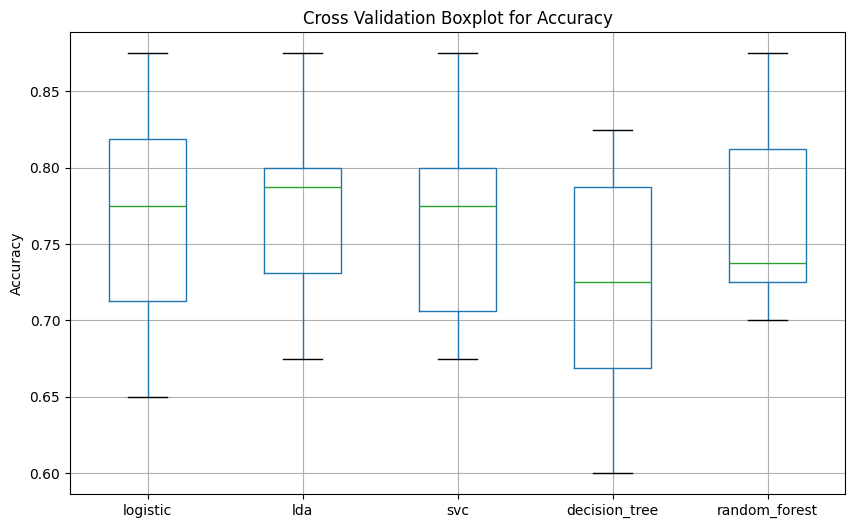

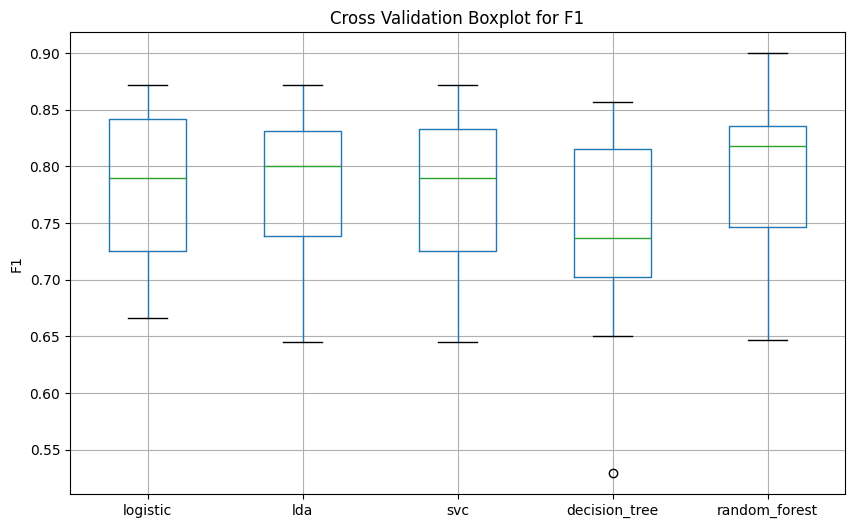

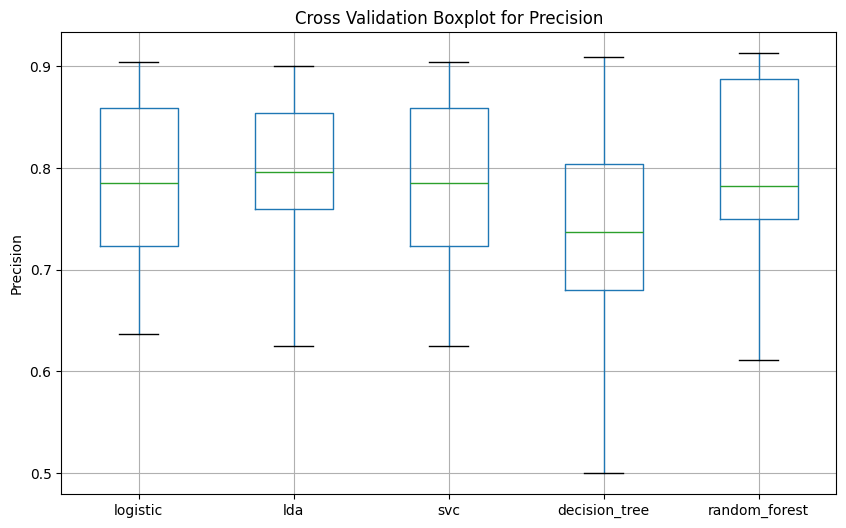

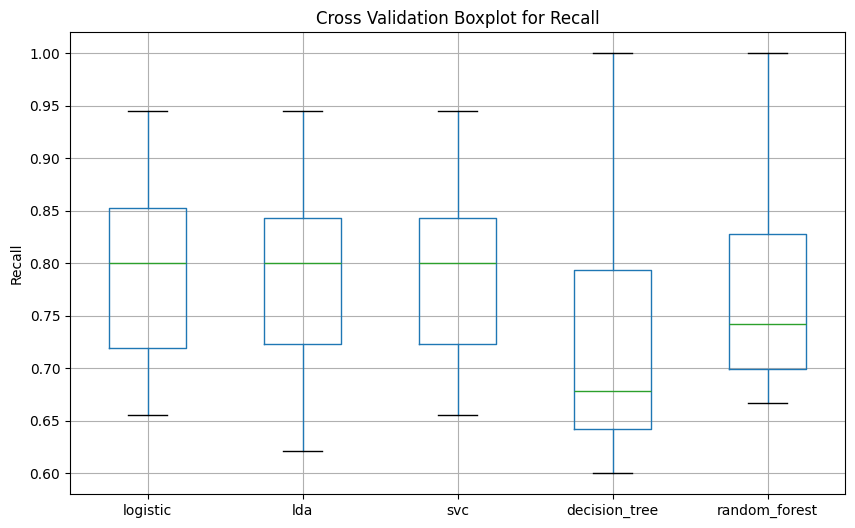

In [39]:
# Create a boxplot for the cross-validation results of each metric
for metric_name in scoring_metrics:
    plt.figure(figsize=(10, 6))
    cv_results_df[metric_name].boxplot()
    plt.title(f"Cross Validation Boxplot for {metric_name.capitalize()}")
    plt.ylabel(f"{metric_name.capitalize()}")
    plt.show()

### **Chosen Metric: Recall**

#### **Why Recall?**
For heart disease prediction, **recall** is the most important metric because the primary goal is to **correctly identify as many patients with heart disease as possible**. Missing a case of heart disease (false negative) can have severe consequences, including delayed diagnosis and treatment, which could be life-threatening.

#### **Understanding Recall in This Context**
- **High recall** ensures that most patients who actually have heart disease are correctly classified as positive cases.  
- **False negatives (missed cases of heart disease)** are minimized, reducing the risk of undiagnosed conditions.  
- **False positives (healthy patients misclassified as having heart disease)** are a less critical issue compared to false negatives because additional medical tests can confirm the diagnosis.  


#### **Conclusion**
Since the model's objective is to **prioritize detecting heart disease cases**, **recall is the best metric** for evaluation. A model with high recall ensures that the majority of patients at risk receive further medical attention, ultimately improving early detection and treatment outcomes.

#### **Statistical Model Comparison**

In [40]:
result_df = cv_results_df["recall"]
result_df

,logistic,lda,svc,decision_tree,random_forest
0,0.863636,0.863636,0.863636,0.772727,0.727273
1,0.700000,0.750000,0.750000,0.650000,0.750000
2,0.655172,0.620690,0.655172,0.689655,0.689655
3,0.800000,0.800000,0.800000,0.640000,0.680000
4,0.714286,0.714286,0.714286,0.619048,0.666667
5,0.944444,0.944444,0.944444,1.000000,1.000000
6,0.800000,0.800000,0.800000,0.850000,0.850000
7,0.840000,0.800000,0.800000,0.800000,0.760000
8,0.733333,0.666667,0.666667,0.600000,0.733333
9,0.857143,0.857143,0.857143,0.666667,0.904762


In [41]:
from scipy.stats import f_oneway

model1 = result_df["logistic"]
model2 = result_df["lda"]
model3 = result_df["decision_tree"]
model4 = result_df["random_forest"]
model5 = result_df["svc"]

statistic, p_value = f_oneway(model1, model2, model3, model4, model5)

print(f"Statistic: {statistic}")
print(f"p_value: {p_value}")

alpha = 0.05  # significance level

if p_value < alpha:
    print(
        "There is a statistically significant difference "
        "in the cross-validation results of the models."
    )
else:
    print(
        "There is no statistically significant difference "
        "in the cross-validation results of the models."
    )

Statistic: 0.5859757938564435
p_value: 0.67442077399164
There is no statistically significant difference in the cross-validation results of the models.


Statistically all the models are similar, so two models are selected to be tuned in the next step:

#### **Model Selection for Hyperparameter Tuning**

For the next stage of hyperparameter tuning, two models have been selected based on the primary metric: **recall**.

#### Analysis of Results:
- **Logistic Regression** has the highest average recall (**0.7879**) with a standard deviation of **0.1314**.
- **LDA and SVC** have very similar recall values (**0.7832**), but they do not outperform Logistic Regression.
- **Random Forest** has a competitive recall (**0.7791**) with a lower standard deviation (**0.0851**), indicating more stability in performance.
- **Decision Tree** has the lowest recall (**0.7401**) and is therefore discarded.

#### Selected Models:
1. **Logistic Regression** – Highest recall and good stability.
2. **Random Forest** – Good recall with lower variability, suggesting better generalization.

These models will be fine-tuned in the next stage to enhance their performance in heart disease prediction. 


#### **Logistic Regression**

In [42]:
from sklearn.model_selection import GridSearchCV

score = "recall"

parameters = {
    "model__penalty": ["l1", "l2"],
    "model__C": [0.1, 0.4, 0.8, 1, 2, 5],
    "model__solver": ["liblinear", "lbfgs", "saga", "newton-cg"]
}

model = LogisticRegression(solver="liblinear")
logistic_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

grid_search = GridSearchCV(
    logistic_pipe, parameters, cv=5, scoring=score, return_train_score=True
)
grid_search.fit(x_train, y_train)


/Users/simon/Documents/CDProduccion/Heart-disease/senv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/simon/Documents/CDProduccion/Heart-disease/senv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/simon/Documents/CDProduccion/Heart-disease/senv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/simon/Documents/CDProduccion/Heart-disease/senv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/simon/Documents/CDProduccion/Heart-disease/senv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Conver

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['age',
                                                                          'max_hr',
                                                                          'rest_bp',
                                                                          'old_peak']),
                                                                        ('nominal_categoric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(drop='if_binary'))]),
                                                                         ['chest_pai...
                                                                                                              func=<function convert_to_int at 0x123fdfb00>)),
                                                                                         ('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(drop='if_binary'))]),
                                                                         ['exang'])])),
                                       ('model',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'model__C': [0.1, 0.4, 0.8, 1, 2, 5],
                         'model__penalty': ['l1', 'l2'],
                         'model__solver': ['liblinear', 'lbfgs', 'saga',
                                           'newton-cg']},
             return_train_score=True, scoring='recall')

In [43]:
grid_search.best_params_

{'model__C': 0.1, 'model__penalty': 'l1', 'model__solver': 'liblinear'}

#### **Evaluating Logistic Regression**

In [44]:
model = LogisticRegression(solver="liblinear", C=0.4, penalty="l1")
logistic_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

logistic_model = logistic_pipe.fit(x_train, y_train)

y_pred = logistic_model.predict(x_test)

summarize_classification(y_test, y_pred)


{'accuracy': 0.7623762376237624,
 'precision': 0.7924528301886793,
 'recall': 0.7636363636363637,
 'f1': 0.7777777777777778,
 'roc': np.float64(0.7622529644268775)}

#### **Random Forest**

In [45]:
from sklearn.model_selection import GridSearchCV

score = "recall"

parameters = {
    "model__max_depth": [4, 5, 7, 9, 10],
    "model__max_features": [2, 3, 4, 5, 6, 7, 8, 9],
    "model__criterion": ["gini", "entropy"],
}

randomforest_pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", RandomForestClassifier())]
)

grid_search = GridSearchCV(
    randomforest_pipe, parameters, cv=5, scoring=score, return_train_score=True
)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['age',
                                                                          'max_hr',
                                                                          'rest_bp',
                                                                          'old_peak']),
                                                                        ('nominal_categoric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(drop='if_binary'))]),
                                                                         ['chest_pai...
                                                                                                              func=<function convert_to_int at 0x123fdfb00>)),
                                                                                         ('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(drop='if_binary'))]),
                                                                         ['exang'])])),
                                       ('model', RandomForestClassifier())]),
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [4, 5, 7, 9, 10],
                         'model__max_features': [2, 3, 4, 5, 6, 7, 8, 9]},
             return_train_score=True, scoring='recall')

In [46]:
grid_search.best_params_

{'model__criterion': 'entropy',
 'model__max_depth': 7,
 'model__max_features': 9}

#### **Evaluating Random Forest**

In [48]:
model = RandomForestClassifier(criterion="entropy", max_depth=7, max_features=9)

tree_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

tree_model = tree_pipe.fit(x_train, y_train)
y_pred = tree_model.predict(x_test)

summarize_classification(y_test, y_pred)


{'accuracy': 0.7920792079207921,
 'precision': 0.8148148148148148,
 'recall': 0.8,
 'f1': 0.8073394495412844,
 'roc': np.float64(0.791304347826087)}

### **6. Final Evaluation Test**

In [49]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    classification_report,
)

#### **Logistic Regression**

In [50]:
y_pred = logistic_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.76      0.74        46
           1       0.79      0.76      0.78        55

    accuracy                           0.76       101
   macro avg       0.76      0.76      0.76       101
weighted avg       0.76      0.76      0.76       101



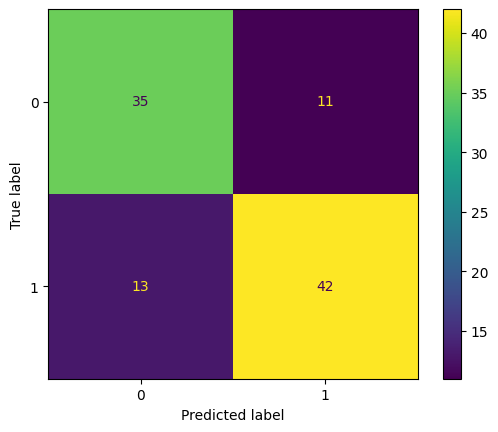

In [51]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

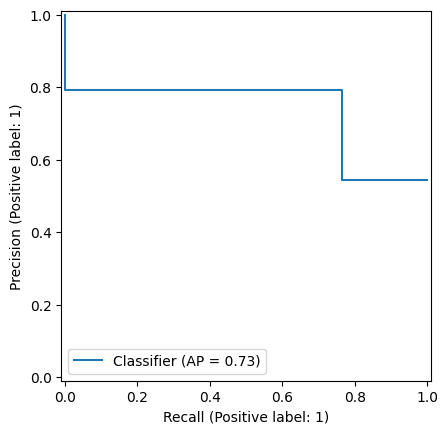

In [52]:
PrecisionRecallDisplay.from_predictions(y_test, y_pred);

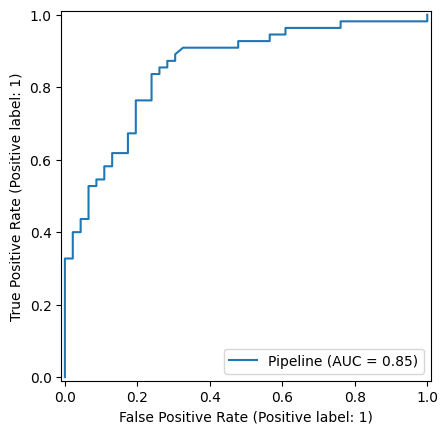

In [53]:
log_plot = RocCurveDisplay.from_estimator(logistic_model, x_test, y_test)
plt.show()

#### **Random Forest**

In [54]:
y_pred = tree_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.78      0.77        46
           1       0.81      0.80      0.81        55

    accuracy                           0.79       101
   macro avg       0.79      0.79      0.79       101
weighted avg       0.79      0.79      0.79       101



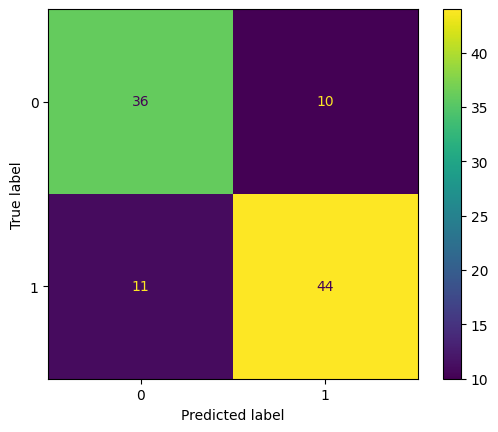

In [55]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

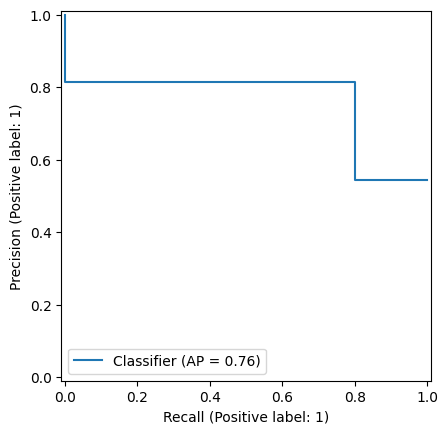

In [56]:
PrecisionRecallDisplay.from_predictions(y_test, y_pred);

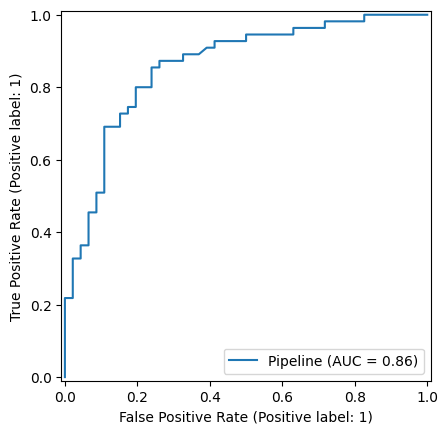

In [57]:
dt_plot = RocCurveDisplay.from_estimator(tree_model, x_test, y_test)
plt.show()

### **7. Model Comparison**

Recall values are similar but Random Forest seems to have a better performance. This is best model according to the CV evaluationa and tuning.

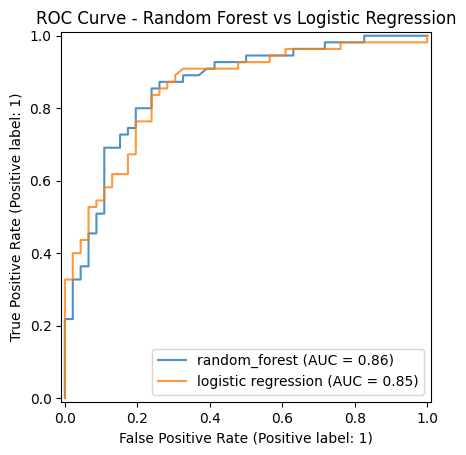

In [58]:
ax = plt.gca()
dt_plot.plot(ax=ax, alpha=0.8, name="random_forest")
log_plot.plot(ax=ax, alpha=0.8, name="logistic regression")
plt.title("ROC Curve - Random Forest vs Logistic Regression")
plt.show()

#### **Random Forest Learning Curve**
This curve is used to see if the model is overfitting or underfitting.

/Users/simon/Documents/CDProduccion/Heart-disease/senv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/simon/Documents/CDProduccion/Heart-disease/senv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/Documents/CDProduccion/Heart-disease/senv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/simon/Documents/CDProduccion/Heart-disease/senv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 

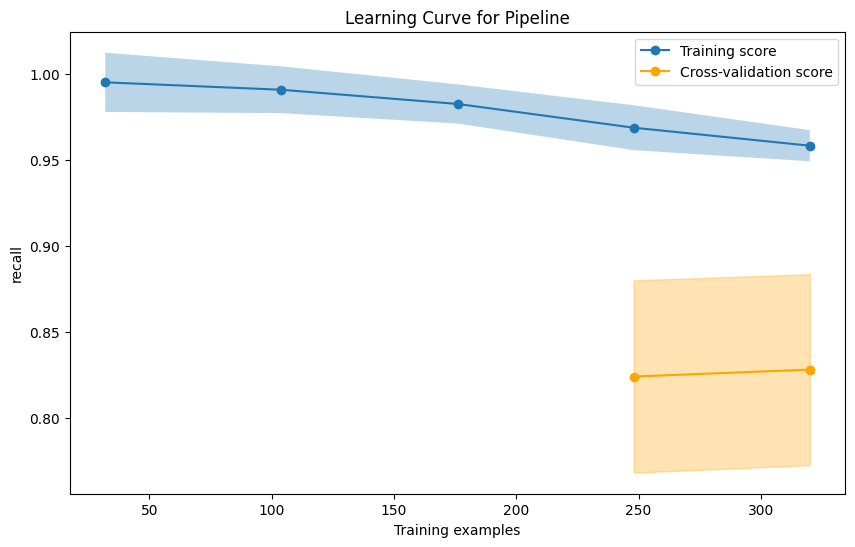

Training Sizes: [ 32 104 176 248 320]
Training Scores Mean: [0.99495051 0.99062458 0.98237858 0.96856996 0.95809532]
Training Scores Std: [0.01721525 0.01360766 0.01139877 0.01306248 0.0090663 ]
Test Scores Mean: [       nan        nan        nan 0.82383826 0.82787851]
Test Scores Std: [       nan        nan        nan 0.05593125 0.05552252]


In [59]:
model = tree_model

# Parameters for the learning curve
common_params = {
    "X": x_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=123),
    "n_jobs": -1,
    "return_times": True,
}

scoring_metric = "recall"

# Obtain the learning curve values including fit and score times
train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
    model, **common_params, scoring=scoring_metric
)

# Calculate the mean and standard deviation of the scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Calculate the mean and standard deviation of the fit and score times
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)
score_times_mean = np.mean(score_times, axis=1)
score_times_std = np.std(score_times, axis=1)

# Plot the learning curve
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)
ax.plot(train_sizes, train_mean, "o-", label="Training score")
ax.plot(train_sizes, test_mean, "o-", color="orange", label="Cross-validation score")
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.3)
ax.fill_between(
    train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.3, color="orange"
)

# Configure the title and labels
ax.set_title(f"Learning Curve for {model.__class__.__name__}")
ax.set_xlabel("Training examples")
ax.set_ylabel(scoring_metric)
ax.legend(loc="best")

# Show the plot
plt.show()

# Print the values for analysis
print("Training Sizes:", train_sizes)
print("Training Scores Mean:", train_mean)
print("Training Scores Std:", train_std)
print("Test Scores Mean:", test_mean)
print("Test Scores Std:", test_std)


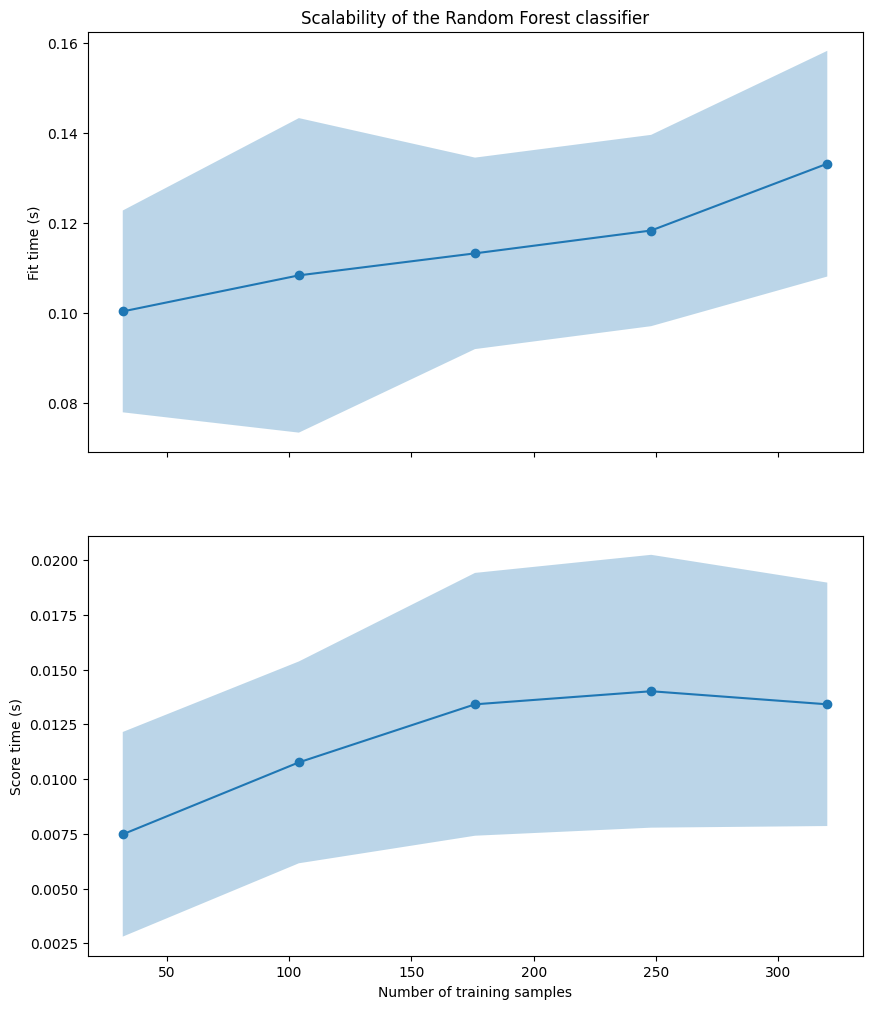

Fit Times Mean: [0.10032145 0.10832467 0.11321058 0.11828161 0.13311639]
Fit Times Std: [0.02239611 0.03490905 0.02125059 0.02123425 0.02505168]
Score Times Mean: [0.00747772 0.01076409 0.01341522 0.01401235 0.01341521]
Score Times Std: [0.00467341 0.00460912 0.00600209 0.00623092 0.00555965]


In [60]:
# Plot the scalability regarding fit time and score time
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 12), sharex=True)

# Scalability regarding the fit time
ax[0].plot(train_sizes, fit_times_mean, "o-")
ax[0].fill_between(
    train_sizes,
    fit_times_mean - fit_times_std,
    fit_times_mean + fit_times_std,
    alpha=0.3,
)
ax[0].set_ylabel("Fit time (s)")
ax[0].set_title("Scalability of the Random Forest classifier")

# Scalability regarding the score time
ax[1].plot(train_sizes, score_times_mean, "o-")
ax[1].fill_between(
    train_sizes,
    score_times_mean - score_times_std,
    score_times_mean + score_times_std,
    alpha=0.3,
)
ax[1].set_ylabel("Score time (s)")
ax[1].set_xlabel("Number of training samples")

# Show the plot
plt.show()

# Print the fit and score times for analysis
print("Fit Times Mean:", fit_times_mean)
print("Fit Times Std:", fit_times_std)
print("Score Times Mean:", score_times_mean)
print("Score Times Std:", score_times_std)

#### **8. Save the model**

In [61]:
tree_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['age', 'max_hr', 'rest_bp',
                                                   'old_peak']),
                                                 ('nominal_categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  ['chest_pain', 'rest_ecg',
                                                   'thal', 'sex'])...
                                                                   OrdinalEncoder())]),
                                                  ['ca', 'slope']),
                                                 ('boolean',
                                                  Pipeline(steps=[('to_int',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function convert_to_int at 0x123fdfb00>)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  ['exang'])])),
                ('model',
                 RandomForestClassifier(criterion='entropy', max_depth=7,
                                        max_features=9))])

In [62]:
from joblib import dump

# Save the model
dump(tree_pipe, "heart_disease_classification-random_forest-v1.joblib")

['heart_disease_classification-random_forest-v1.joblib']

In [63]:
['tree_pipe-titanic.joblib']

['tree_pipe-titanic.joblib']

#### **7. Test the saved model**

In [64]:
from joblib import load

my_model = load("heart_disease_classification-random_forest-v1.joblib")

In [65]:
# test data
x_test.head()

,rest_ecg,ca,thal,max_hr,exang,old_peak,rest_bp,chest_pain,sex,slope,age
601,NaN,1.0,normal,NaN,False,0.0,NaN,NaN,NaN,1.0,52.0
535,normal,0.0,fixed,132.0,False,0.0,135.0,nontypical,Male,2.0,NaN
691,left ventricular hypertrophy,0.0,normal,155.0,False,3.0,140.0,nonanginal,Male,2.0,60.0
408,normal,0.0,normal,123.0,False,0.6,110.0,nonanginal,Male,1.0,51.0
1649,NaN,0.0,reversable,140.0,True,3.4,NaN,NaN,NaN,3.0,59.0


In [66]:
# check predictions
my_model.predict(x_test.head())

array([0, 0, 1, 0, 1])

### **Analysis of Results**

The **selected model** is **Random Forest**, as it achieves a **higher recall**, which is the key metric for evaluation.

#### **Model Performance**
Random Forest achieves an **accuracy of 79%**, outperforming Logistic Regression, which reached **76% accuracy**.

#### **Recall (Sensitivity) - Key Metric** 
- Logistic Regression: **0.76 for class 0** and **0.76 for class 1**.  
- Random Forest: **0.78 for class 0** and **0.80 for class 1**.  

Random Forest improves recall for both classes, especially for class 1, which is crucial for identifying positive cases correctly.

#### **Precision and F1-Score**
- Precision: Random Forest has slightly better precision (**0.77 for class 0**, **0.81 for class 1**) compared to Logistic Regression (**0.73 for class 0**, **0.79 for class 1**).  
- F1-Score: Higher in Random Forest (**0.79 macro avg**) than in Logistic Regression (**0.76 macro avg**), indicating a better balance between precision and recall.

#### **Final Decision**  
Since **recall** is the most important metric, **Random Forest** is the best choice, as it minimizes false negatives while maintaining strong overall performance. 🚀
